In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

%matplotlib inline
sns.set(color_codes=True)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Load and Sample the Dataset

In [4]:
df = pd.read_csv('adverts.csv')

In [5]:
df.shape

(402005, 12)

In [6]:
df.head()

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,2.020060e+14,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,2.020070e+14,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,2.020070e+14,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,2.020070e+14,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,2.020070e+14,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel


# 1. Data Description and Pre-Processing

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  float64
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(3), int64(1), object(7)
memory usage: 34.1+ MB


In [8]:
df.describe()

,public_reference,mileage,year_of_registration,price
count,4.020050e+05,401878.000000,368694.000000,4.020050e+05
mean,2.020069e+14,37743.595656,2015.006206,1.734197e+04
std,1.691466e+10,34831.724018,7.962667,4.643746e+04
min,2.013070e+14,0.000000,999.000000,1.200000e+02
25%,2.020090e+14,10481.000000,2013.000000,7.495000e+03
50%,2.020090e+14,28629.500000,2016.000000,1.260000e+04
75%,2.020100e+14,56875.750000,2018.000000,2.000000e+04
max,2.020110e+14,999999.000000,2020.000000,9.999999e+06


In [9]:
# Check for missing values
df.isnull().sum()

,0
public_reference,0
mileage,127
reg_code,31857
standard_colour,5378
standard_make,0
standard_model,0
vehicle_condition,0
year_of_registration,33311
price,0
body_type,837


In [10]:
df.dtypes

,0
public_reference,float64
mileage,float64
reg_code,object
standard_colour,object
standard_make,object
standard_model,object
vehicle_condition,object
year_of_registration,float64
price,int64
body_type,object


In [11]:
# Preprocess dataset: sampling, cleaning, encoding, scaling, and splitting

def preprocess_data(df, target_col='price', sample_frac=0.1, random_state=42):

    # Step 1: Sampling (if sample_frac < 1.0)
    if sample_frac < 1.0:
        df = df.sample(frac=sample_frac, random_state=random_state)
        print(f"Sampled dataset shape: {df.shape}")
    else:
        print(f"Using full dataset: {df.shape}")

    # Step 2: Identify types
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object']).columns

    # Step 3: Handle missing values
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[num_cols] = num_imputer.fit_transform(df[num_cols])
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    # Step 4: Handle outliers (IQR)
    def cap_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return np.clip(series, lower, upper)

    for col in num_cols:
        df[col] = cap_outliers(df[col])

    # Step 5: Reduce high-cardinality categorical variables
    def reduce_categories(series, top_n=10):
        top = series.value_counts().nlargest(top_n).index
        return series.where(series.isin(top), other='Other')

    for col in cat_cols:
        df[col] = reduce_categories(df[col])

    # Step 6: Encode categorical variables
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    # Step 7: Drop duplicates after missing value handling and encoding
    df = df.drop_duplicates()
    print(f"After dropping duplicates: {df.shape}")

    # Step 8: Scale numerical features
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Step 9: Train/Val/Test split
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test, df


### Visualization Function

In [12]:
# Efficient visualizations: missing values, correlations, distributions, categorical plots

def visualize_data(df_sample, target_col='price'):

    # 1. Bar Plot: Missing value counts
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing.values, y=missing.index, palette='magma')
    plt.title('Missing Values per Feature')
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(10, 6))
    corr = df_sample.select_dtypes(include=['float64', 'int64']).corr()
    sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.show()

    # Target distribution
    plt.figure(figsize=(10,6))
    sns.histplot(df_sample[target_col], kde=True, bins=30)
    plt.title(f'Distribution of {target_col}')
    plt.xlabel(target_col)
    plt.ylabel('Frequency')
    plt.show()

    # Boxplot: Price by Standard Make
    if 'standard_make' in df_sample.columns:
        top_makes = df_sample['standard_make'].value_counts().nlargest(10).index
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='standard_make', y='price',
                    data=df_sample[df_sample['standard_make'].isin(top_makes)],
                    palette='Set3')
        plt.title('Price Distribution by Top 10 Car Makes')
        plt.xlabel('Standard Make')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Distributions of top numerical features
    top_num_cols = df_sample.select_dtypes(include=['float64', 'int64']).columns[:5]
    df_sample[top_num_cols].hist(figsize=(15, 10), bins=30, layout=(2,3))
    plt.suptitle('Distributions of Numerical Features')
    plt.show()

    # 4. IQR-based outlier count per numeric feature
    num_cols = df_sample.select_dtypes(include=['float64', 'int64']).columns
    outlier_counts = {}

    for col in num_cols:
        Q1 = df_sample[col].quantile(0.25)
        Q3 = df_sample[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df_sample[(df_sample[col] < lower_bound) | (df_sample[col] > upper_bound)]
        outlier_counts[col] = outliers.shape[0]

    outlier_series = pd.Series(outlier_counts).sort_values(ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=outlier_series.values, y=outlier_series.index, palette='Reds_r')
    plt.title('Outlier Count per Feature (IQR Method)')
    plt.xlabel('Number of Outliers')
    plt.tight_layout()
    plt.show()

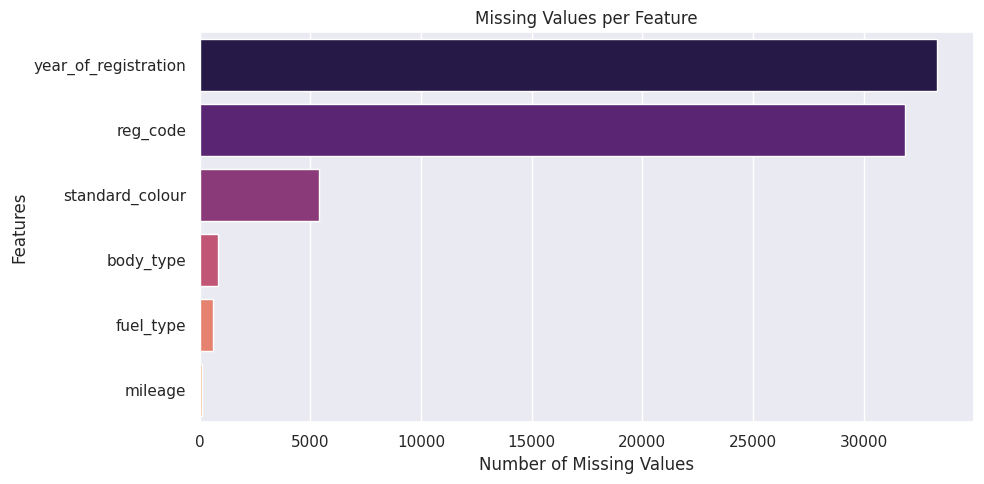

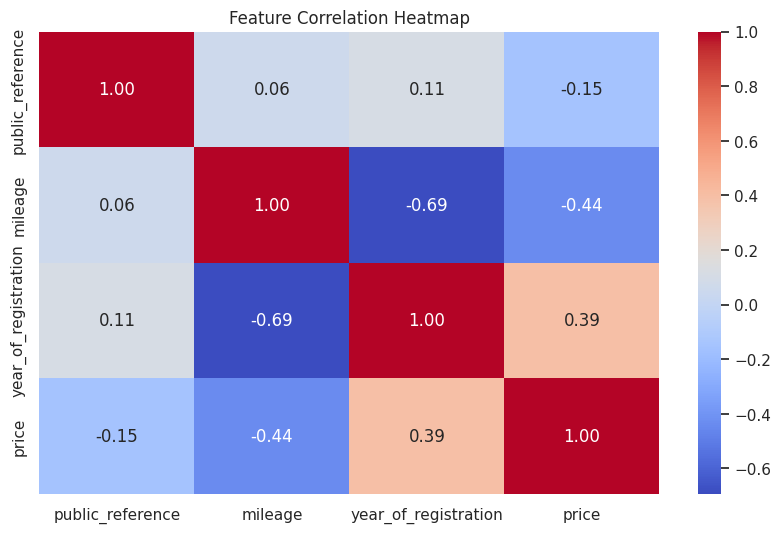

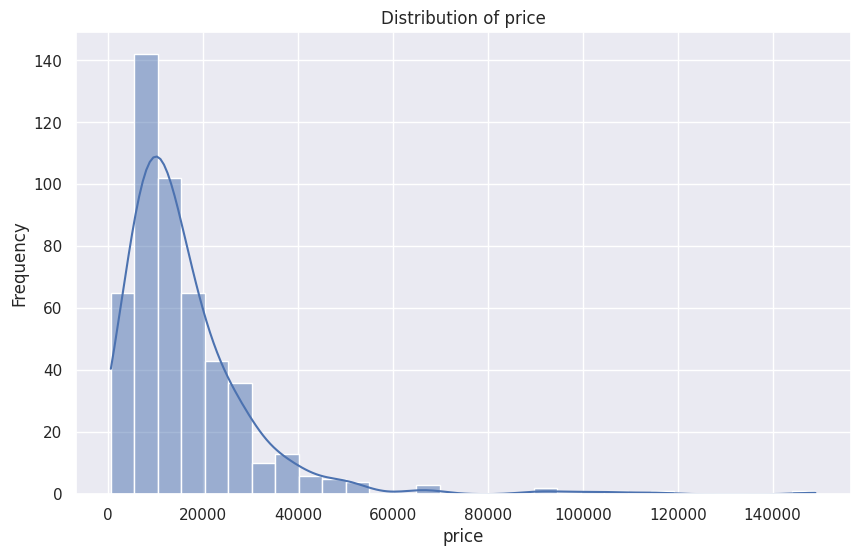

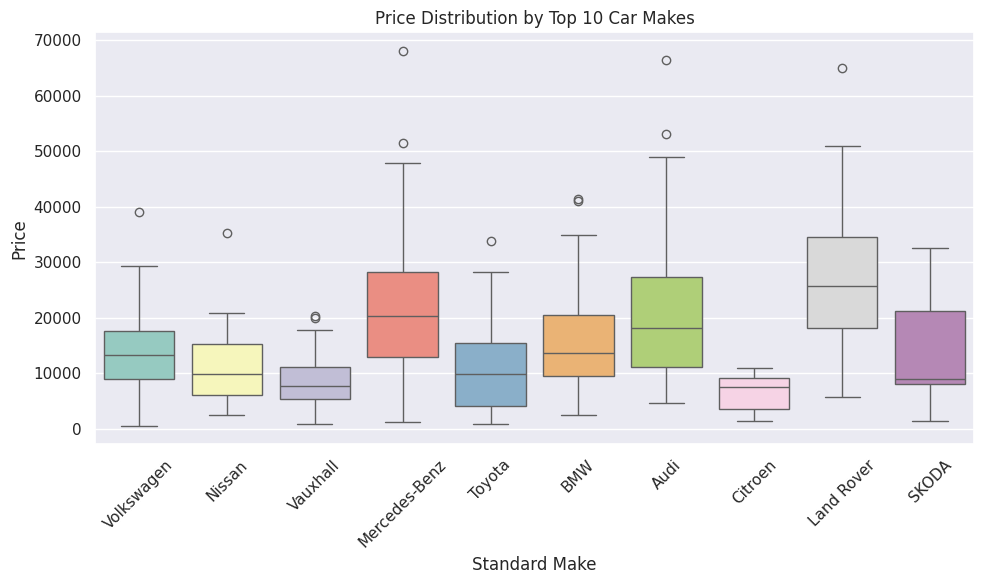

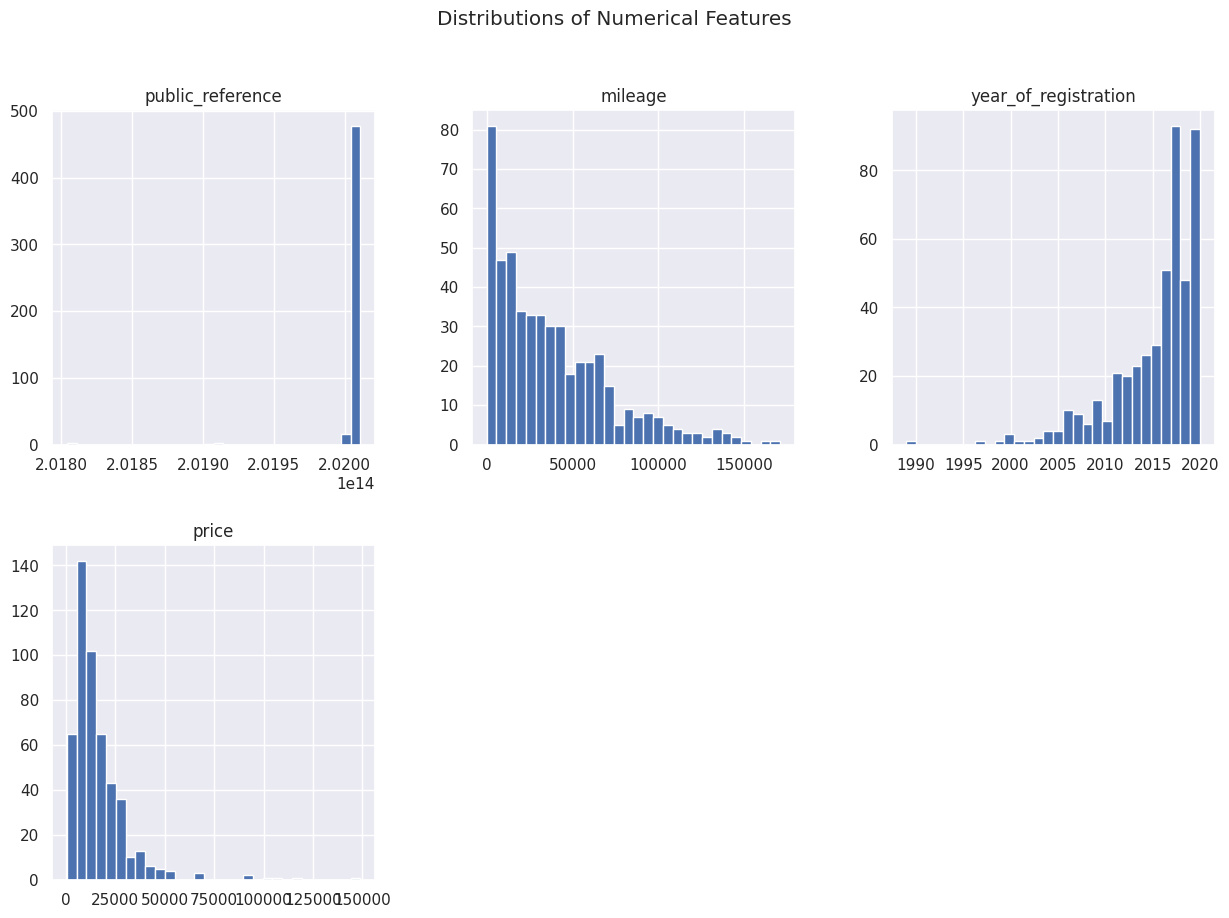

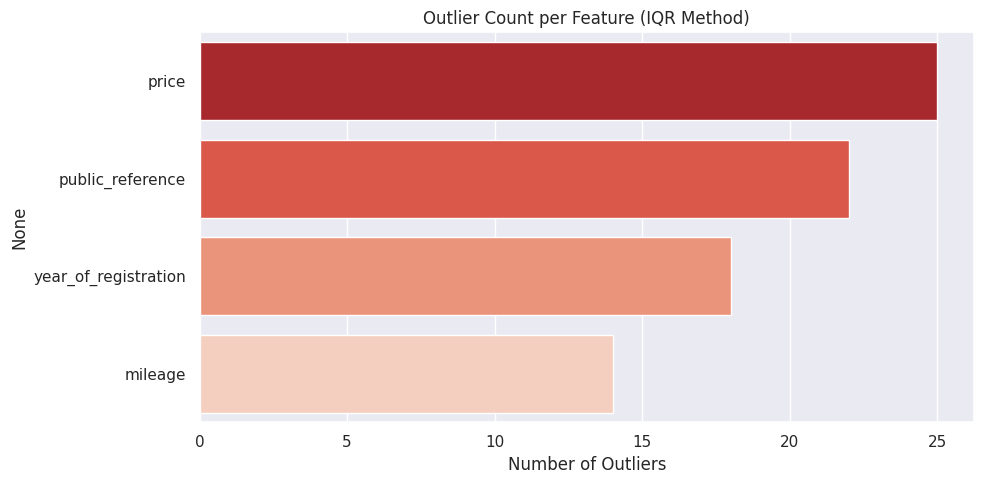

In [13]:
df_sample = df.sample(500, random_state=42)
visualize_data(df_sample)

### Preprocessing a Sample for Prototyping

In [14]:
# Preprocess 10% sample
X_train_sample, X_val_sample, X_test_sample, y_train_sample, y_val_sample, y_test_sample, df_sample = preprocess_data(df, target_col='price', sample_frac=0.1)

Sampled dataset shape: (40200, 12)
After dropping duplicates: (39754, 12)


### Preprocessing the Full Dataset for Final Models

In [15]:
X_train_full, X_val_full, X_test_full, y_train_full, y_val_full, y_test_full, df_full = preprocess_data(df, target_col='price', sample_frac=1.0)

Using full dataset: (402005, 12)
After dropping duplicates: (388691, 12)


# Part-I

# 2. Automated Feature Selection

### Method 1: Variance Threshold

In [16]:
# Threshold: remove features with near-zero variance
selector_var = VarianceThreshold(threshold=0.01)
selector_var.fit(X_train_sample)

VarianceThreshold(threshold=0.01)

In [17]:
# Selected features
selected_features_var = X_train_sample.columns[selector_var.get_support()]
print(f"Selected features using Variance Threshold:{len(selected_features_var)}")
print(selected_features_var.tolist())

Selected features using Variance Threshold:10
['public_reference', 'mileage', 'reg_code', 'standard_colour', 'standard_make', 'standard_model', 'vehicle_condition', 'year_of_registration', 'body_type', 'fuel_type']


### Method 2: SelectKBest (with f_regression)

In [18]:
# Select top 20 features
selector_kbest = SelectKBest(score_func=f_regression, k=20)
selector_kbest.fit(X_train_sample, y_train_sample)

SelectKBest(k=20, score_func=<function f_regression at 0x7924582ecae0>)

In [19]:
selected_features_kbest = X_train_sample.columns[selector_kbest.get_support()]
print(f"Features selected by SelectKBest: {len(selected_features_kbest)}")
print(selected_features_kbest.tolist())

Features selected by SelectKBest: 11
['public_reference', 'mileage', 'reg_code', 'standard_colour', 'standard_make', 'standard_model', 'vehicle_condition', 'year_of_registration', 'body_type', 'crossover_car_and_van', 'fuel_type']


### Method 3: Recursive Feature Elimination (RFE)

In [20]:
base_model_rfe = RandomForestRegressor(random_state=42)
selector_rfe = RFE(base_model_rfe, n_features_to_select=20)
selector_rfe.fit(X_train_sample, y_train_sample)

RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=20)

In [21]:
selected_features_rfe = X_train_sample.columns[selector_rfe.support_]
print(f"Features selected by RFE: {len(selected_features_rfe)}")
print(selected_features_rfe.tolist())

Features selected by RFE: 11
['public_reference', 'mileage', 'reg_code', 'standard_colour', 'standard_make', 'standard_model', 'vehicle_condition', 'year_of_registration', 'body_type', 'crossover_car_and_van', 'fuel_type']


### Model Performance Comparison (RMSE)

In [22]:
def evaluate_model(X_train, X_val, y_train, y_val, selected_features):
  model = RandomForestRegressor(random_state=42)
  model.fit(X_train[selected_features], y_train)
  y_pred = model.predict(X_val[selected_features])
  # rmse = mean_squared_error(y_val, y_pred, squared=False)
  mse = np.mean((y_val - y_pred)**2)
  rmse = np.sqrt(mse)
  return rmse

In [23]:
# Evaluating all methods

rmse_var = evaluate_model(X_train_sample, X_val_sample, y_train_sample, y_val_sample, selected_features_var)
rmse_kbest = evaluate_model(X_train_sample, X_val_sample, y_train_sample, y_val_sample, selected_features_kbest)
rmse_rfe = evaluate_model(X_train_sample, X_val_sample, y_train_sample, y_val_sample, selected_features_rfe)

In [24]:
print(f"Variance Threshold RMSE: {rmse_var: .2f}")
print(f"SelectKBest RMSE: {rmse_kbest: .2f}")
print(f"RMSE for RFE: {rmse_rfe: .2f}")

Variance Threshold RMSE:  0.48
SelectKBest RMSE:  0.48
RMSE for RFE:  0.48


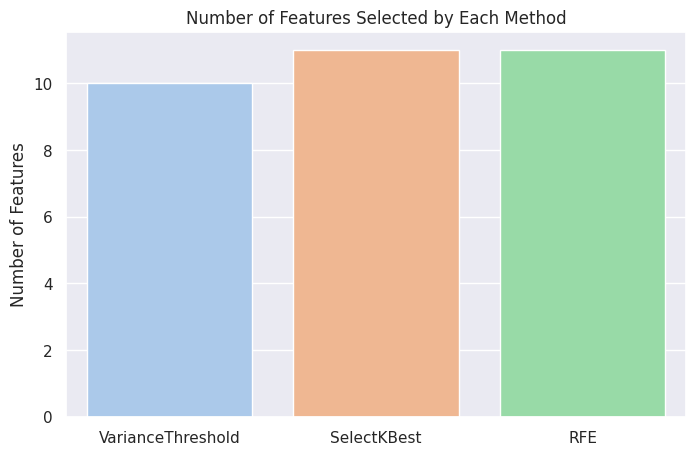

In [25]:
# Number of features selected by each method
methods = ['VarianceThreshold', 'SelectKBest', 'RFE']
num_features = [len(selected_features_var), len(selected_features_kbest), len(selected_features_rfe)]

plt.figure(figsize=(8,5))
sns.barplot(x=methods, y=num_features, palette='pastel')
plt.title('Number of Features Selected by Each Method')
plt.ylabel('Number of Features')
plt.show()

# 3. Tree Ensembles

In [26]:
# Preprocessing for Pipelines
num_cols = X_train_sample.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train_sample.select_dtypes(include=['object']).columns.tolist()

In [27]:
# Preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])
preprocessor.set_output(transform='pandas')

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='median'),
                                 ['public_reference', 'mileage', 'reg_code',
                                  'standard_colour', 'standard_make',
                                  'standard_model', 'vehicle_condition',
                                  'year_of_registration', 'body_type',
                                  'fuel_type']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 [])])

### Random Forest Pipeline

In [28]:
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ))
])

### Train, Predict, Evaluate Random Forest

In [29]:
# Fit
rf_pipeline.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['public_reference',
                                                   'mileage', 'reg_code',
                                                   'standard_colour',
                                                   'standard_make',
                                                   'standard_model',
                                                   'vehicle_condition',
                                                   'year_of_registration',
                                                   'body_type', 'fuel_type']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_split=5,
                                       n_estimators=200, n_jobs=-1,
                                       random_state=42))])

In [30]:
# Predict
y_val_pred_rf = rf_pipeline.predict(X_val_sample)

In [31]:
# Calculating Mean Squared Error
val_mse_rf = mean_squared_error(y_val_sample, y_val_pred_rf)
val_rmse_rf = np.sqrt(val_mse_rf)

print(f"Validation RMSE for Random Forest: {val_rmse_rf: .4f}")

Validation RMSE for Random Forest:  0.4677


### Feature Importance Plot (Random Forest)

In [32]:
# Numeric features
numeric_features = num_cols

# Categorical features
categorical_features = cat_cols

In [33]:
final_feature_names = np.concatenate([numeric_features, categorical_features])

# Access fitted regressor
regressor = rf_pipeline.named_steps['regressor']

# Feature importances
importances = regressor.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

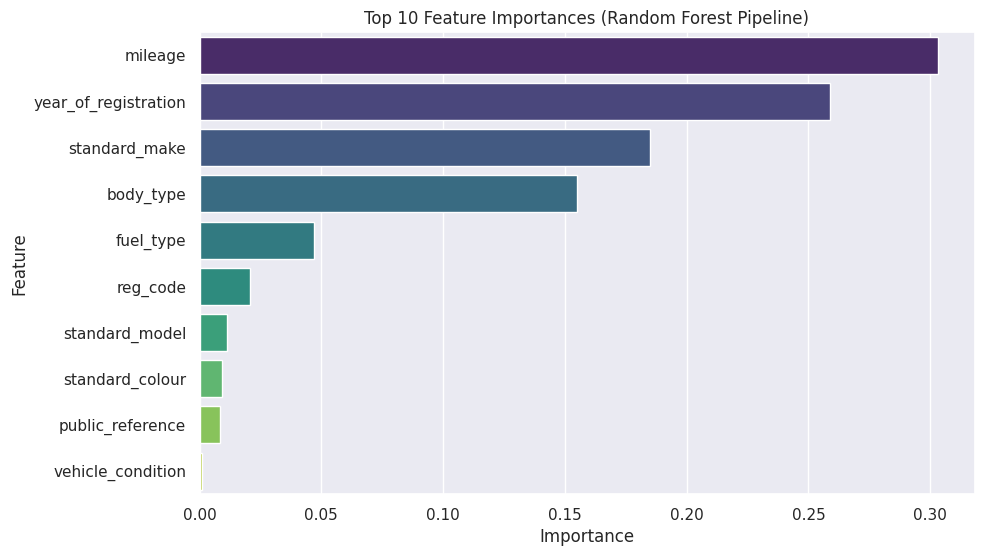

In [34]:
top_features = feature_importances.head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest Pipeline)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Gradient Boosting Pipeline

In [35]:
gb_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    ))
])

### Train, Predict, Evaluate Gradient Boosting

In [36]:
gb_pipeline.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['public_reference',
                                                   'mileage', 'reg_code',
                                                   'standard_colour',
                                                   'standard_make',
                                                   'standard_model',
                                                   'vehicle_condition',
                                                   'year_of_registration',
                                                   'body_type', 'fuel_type']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=5,
                                           n_estimators=200,
                                           random_state=42))])

In [37]:
# Predict
y_val_pred_gb = gb_pipeline.predict(X_val_sample)

In [38]:
# Evaluate
val_mse_gb = mean_squared_error(y_val_sample, y_val_pred_gb)
val_rmse_gb = np.sqrt(val_mse_gb)

print(f"Validation RMSE for Gradient Boosting: {val_rmse_gb: .4f}")

Validation RMSE for Gradient Boosting:  0.4651


In [39]:
final_feature_names = np.concatenate([numeric_features, categorical_features])

# Access fitted regressor
regressor = gb_pipeline.named_steps['regressor']

# Feature importances
importances = regressor.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

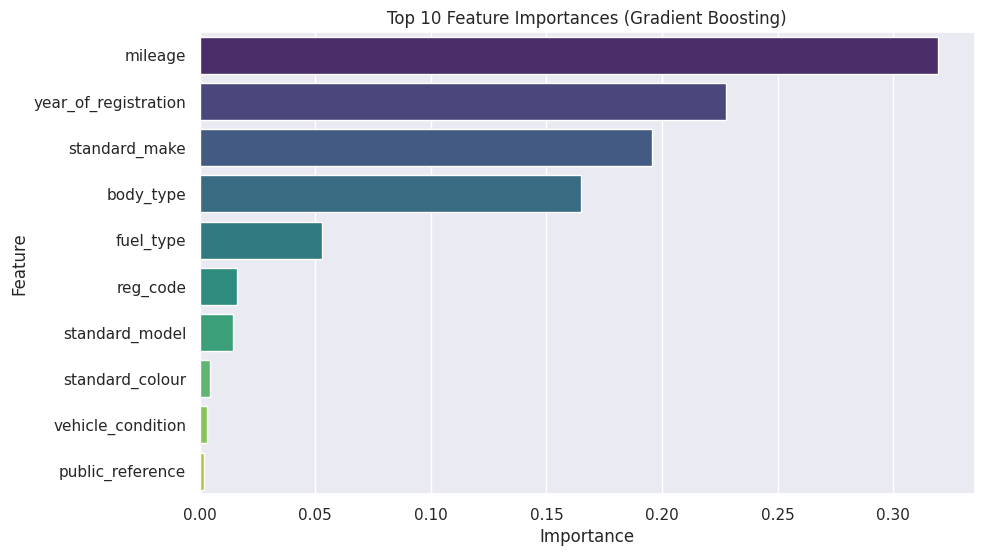

In [40]:
top_features = feature_importances.head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances (Gradient Boosting)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Visual Comparison for Random Forest and Gradient Boosting

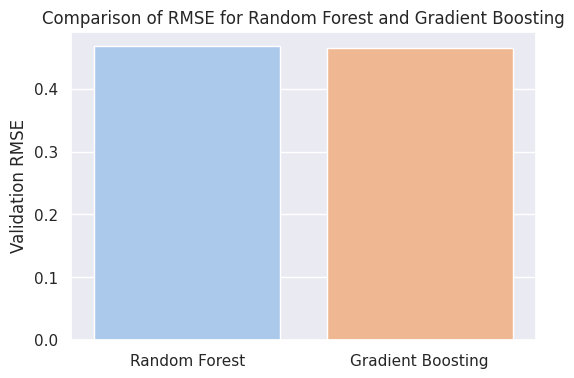

In [41]:
# Models and RMSE values
models = ['Random Forest', 'Gradient Boosting']
rmse_values = [val_rmse_rf, val_rmse_gb]

# Plotting
plt.figure(figsize=(6,4))
sns.barplot(x=models, y=rmse_values, palette='pastel')
plt.title('Comparison of RMSE for Random Forest and Gradient Boosting')
plt.ylabel('Validation RMSE')
plt.show()

# 4. Ensemble of Tree Ensembles

### Average Ensemble

In [42]:
# Average Predictions
avg_preds = (y_val_pred_rf + y_val_pred_gb) / 2
avg_rmse = np.sqrt(mean_squared_error(y_val_sample, avg_preds))

print(f"Average Ensemble RMSE: {avg_rmse: .4f}")

Average Ensemble RMSE:  0.4605


### Stacking Ensemble

In [43]:
# Define stacking model
stack = StackingRegressor(
    estimators=[
        ('rf', rf_pipeline),
        ('gb', gb_pipeline)
    ],
    final_estimator=RidgeCV(),
    passthrough=True,
    n_jobs=-1
)

In [44]:
# Fit stacking model
stack.fit(X_train_sample, y_train_sample)

StackingRegressor(estimators=[('rf',
                               Pipeline(steps=[('preprocessing',
                                                ColumnTransformer(transformers=[('num',
                                                                                 SimpleImputer(strategy='median'),
                                                                                 ['public_reference',
                                                                                  'mileage',
                                                                                  'reg_code',
                                                                                  'standard_colour',
                                                                                  'standard_make',
                                                                                  'standard_model',
                                                                                  'vehicle_condition',
                                                                                  'year_of_registration',
                                                                                  'body_type',
                                                                                  'fuel_type']),
                                                                                ('cat',
                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                               spa...
                                                                                  'standard_colour',
                                                                                  'standard_make',
                                                                                  'standard_model',
                                                                                  'vehicle_condition',
                                                                                  'year_of_registration',
                                                                                  'body_type',
                                                                                  'fuel_type']),
                                                                                ('cat',
                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                               sparse_output=False),
                                                                                 [])])),
                                               ('regressor',
                                                GradientBoostingRegressor(learning_rate=0.05,
                                                                          max_depth=5,
                                                                          n_estimators=200,
                                                                          random_state=42))]))],
                  final_estimator=RidgeCV(), n_jobs=-1, passthrough=True)

In [45]:
# Predict and Evaluate
y_val_pred_stack = stack.predict(X_val_sample)
stack_rmse = np.sqrt(mean_squared_error(y_val_sample, y_val_pred_stack))
stack_r2 = r2_score(y_val_sample, y_val_pred_stack)

print(f"Stacking Ensemble RMSE: {stack_rmse: .4f}")
print(f"Stacking Ensemble R2 Score: {stack_r2: .3f}")

Stacking Ensemble RMSE:  0.4602
Stacking Ensemble R2 Score:  0.790


### Tree-based Ensembles Comparison Plot

In [46]:
methods = ['Random Forest', 'Gradient Boosting', 'Average Ensemble(RF+GB)', 'Stacking Ensemble(RF+GB)']
rmse_values = [val_rmse_rf, val_rmse_gb, avg_rmse, stack_rmse]

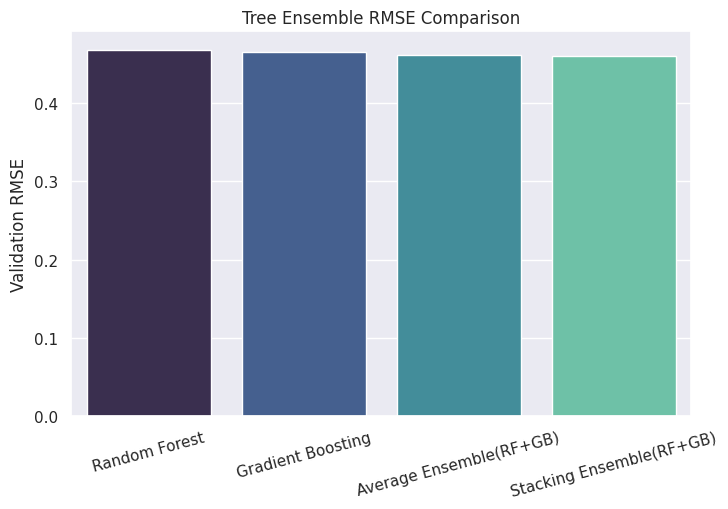

In [47]:
plt.figure(figsize=(8,5))
sns.barplot(x=methods, y=rmse_values, palette='mako')
plt.title('Tree Ensemble RMSE Comparison')
plt.ylabel('Validation RMSE')
plt.xticks(rotation=15)
plt.show()

# 5. Feature Importance

### Permutation Importance (Random Forest Pipeline)

In [48]:
# Computing permutation importances
perm_importance = permutation_importance(
    rf_pipeline,
    X_val_sample,
    y_val_sample,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

In [49]:
# Converting to DataFrame
perm_df = pd.DataFrame({
    'Feature': X_val_sample.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

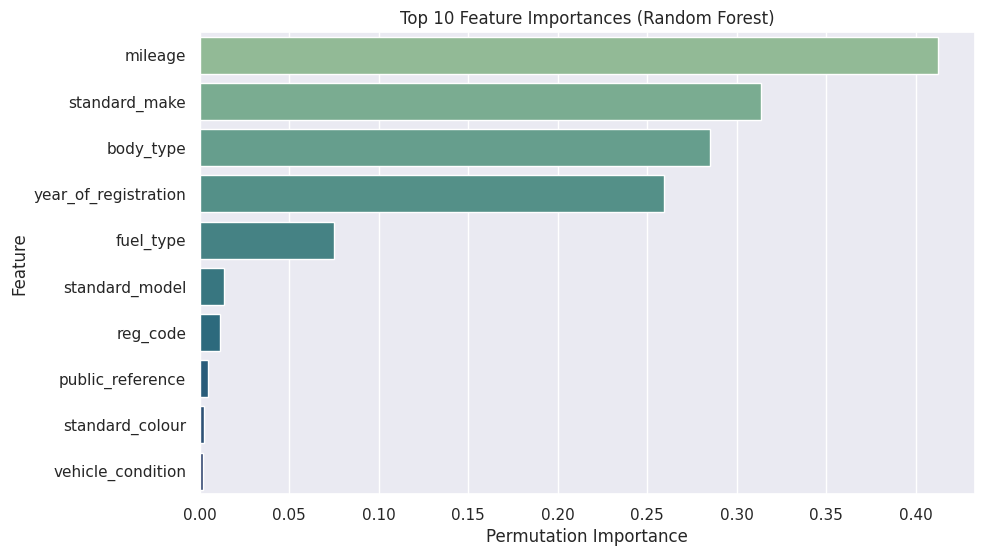

In [50]:
# Plot (top 10)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=perm_df.head(10), palette='crest')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.show()

### SHAP Values (on Gradient Boosting Pipeline)

In [51]:
# Preprocess validation data to get input to model
X_val_transformed = gb_pipeline.named_steps['preprocessing'].transform(X_val_sample)

In [52]:
all_feature_names = X_val_transformed.columns

In [53]:
gb_model = gb_pipeline.named_steps['regressor']

In [54]:
# SHAP explainer
explainer = shap.Explainer(gb_model.predict, X_val_transformed)

In [55]:
X_val_sampled = X_val_transformed.sample(n=100, random_state=42)
shap_values = explainer(X_val_sampled)

ExactExplainer explainer: 101it [00:28,  2.91it/s]


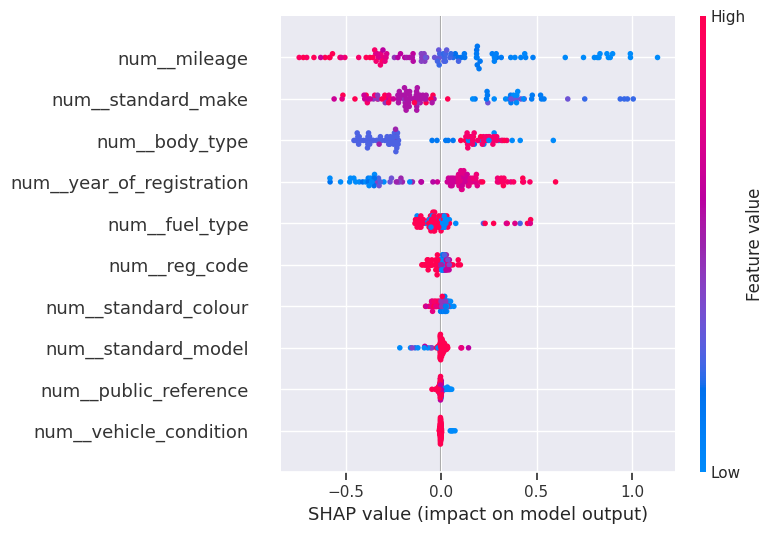

In [56]:
# Summary Plot
shap.summary_plot(
    shap_values,
    features=X_val_sampled,
    feature_names=all_feature_names,
    show=True,
    max_display=10
)

# 6. SHAP/PDP Model Explanations

### SHAP Dependence Plot

In [57]:
for i, name in enumerate(X_val_sampled.columns):
    print(f"{i}: {name}")


0: num__public_reference
1: num__mileage
2: num__reg_code
3: num__standard_colour
4: num__standard_make
5: num__standard_model
6: num__vehicle_condition
7: num__year_of_registration
8: num__body_type
9: num__fuel_type


In [58]:
# Select top features from SHAP summary
top_feature = 'num__mileage'

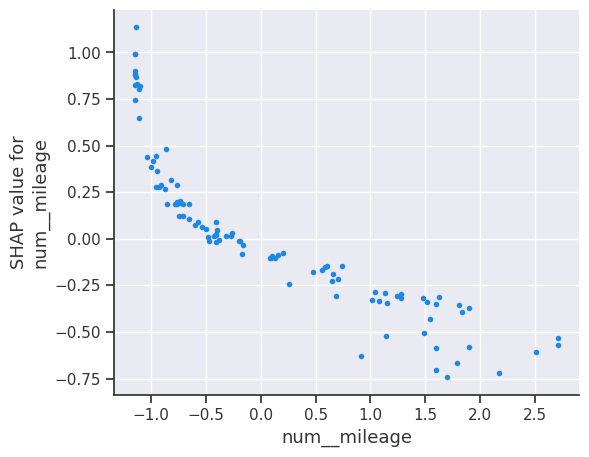

In [59]:
shap.dependence_plot(
    top_feature,
    shap_values.values,
    X_val_sampled,
    feature_names=X_val_sampled.columns,
    interaction_index=None,
    show=True
)

### Partial Dependence Plot (PDP)

In [60]:
top_features = ['num__mileage', 'num__standard_make']

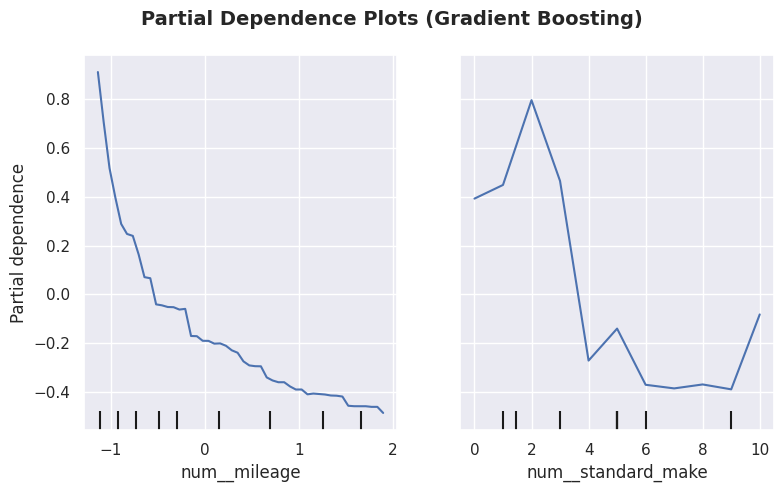

In [61]:
# PDP for Gradient Boosting Pipeline
fig, ax = plt.subplots(figsize=(8,5))
PartialDependenceDisplay.from_estimator(
    gb_model,
    X_val_sampled,
    features=top_features,
    kind='average',
    grid_resolution=50,
    ax=ax
)

plt.suptitle('Partial Dependence Plots (Gradient Boosting)', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

### ICE Plot (Individual Conditional Expectation)

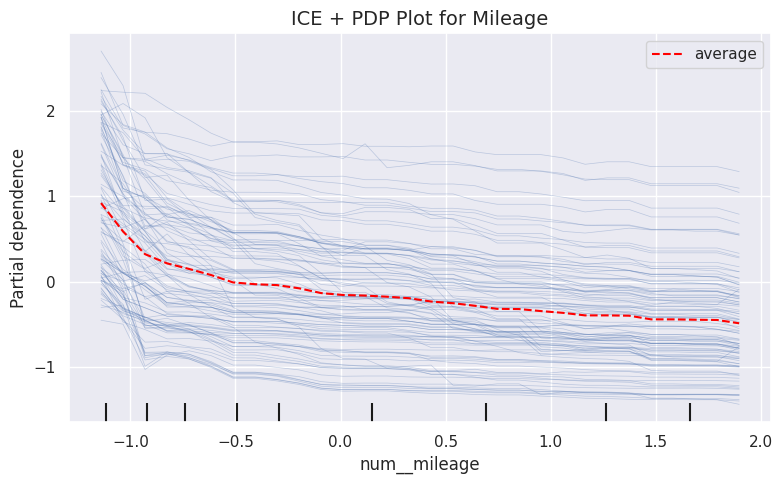

In [62]:
# ICE for one feature
fig, ax = plt.subplots(figsize=(8,5))
PartialDependenceDisplay.from_estimator(
    gb_model,
    X_val_sampled,
    features=['num__mileage'],
    kind='both',
    grid_resolution=30,
    ax=ax,
    pd_line_kw={'color': 'red'}
)
plt.title('ICE + PDP Plot for Mileage', fontsize=14)
plt.tight_layout()
plt.show()

### Evaluate on the test set (Gradient Boosting Pipeline)

In [63]:
y_pred_test = gb_pipeline.predict(X_test_full)

In [64]:
mse_test = mean_squared_error(y_test_full, y_pred_test)  # MSE
rmse_test = np.sqrt(mse_test)  # calculating RMSE from MSE
r2_test = r2_score(y_test_full, y_pred_test)

print(f"Test RMSE: {rmse_test: .2f}")
print(f"Test R^2 Score: {r2_test: .3f}")

Test RMSE:  0.58
Test R^2 Score:  0.668


### Visualization - Predictions vs Actual

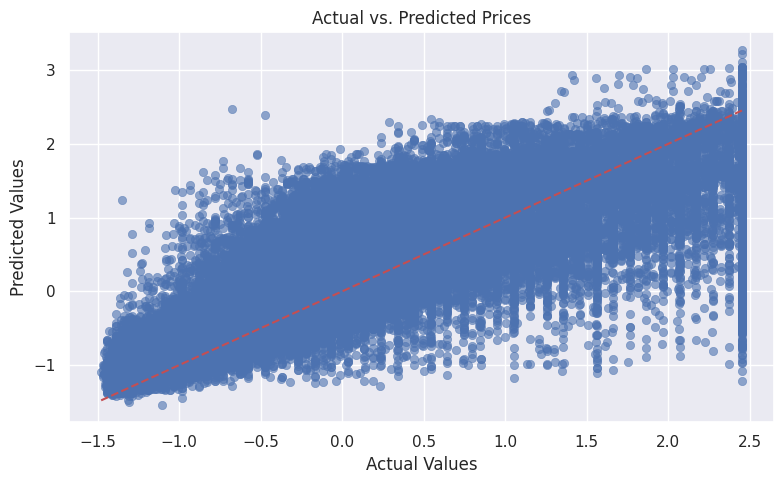

In [65]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_full, y=y_pred_test, alpha=0.6, edgecolor=None)
plt.plot([y_test_full.min(), y_test_full.max()], [y_test_full.min(), y_test_full.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Prices')
plt.tight_layout()
plt.show()

### Clean up memory

In [66]:
import gc

if 'shap_values' in locals() or 'shap_values' in globals():
    del shap_values
if 'explainer' in locals() or 'explainer' in globals():
    del explainer
if 'X_val_sampled' in locals() or 'X_val_sampled' in globals():
    del X_val_sampled

gc.collect()

59644

# Part-II

# 7. Dimensionality Reduction (Linear)

In [67]:
# Selecting numerical columns only
X_num = X_train_full[num_cols].copy()

In [68]:
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

### Apply PCA

Trained a linear regression model with PCA for comparison. While its performance was lower than tree ensembles, it provided a simple and interpretable benchmark. PCA helped remove multicollinearity and reduced overfitting

In [69]:
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_num_scaled)

print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 9


### Scree Plot - Explained Variance

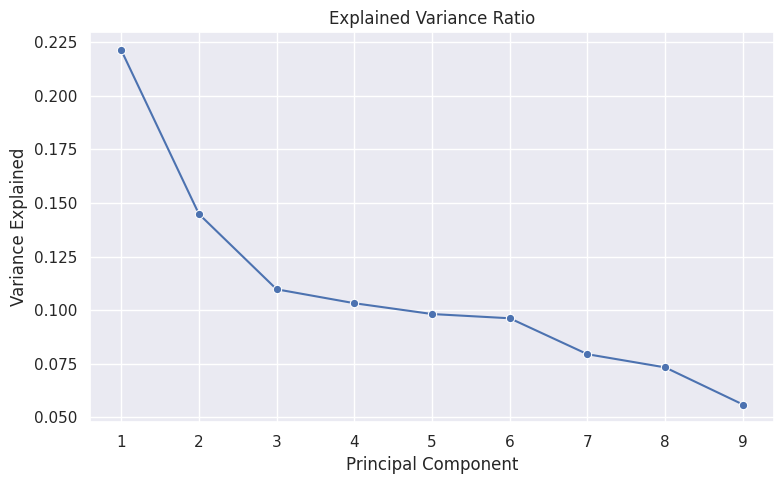

In [70]:
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_)+1), y=pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.tight_layout()
plt.show()

### Cumulative Explained Variance Plot

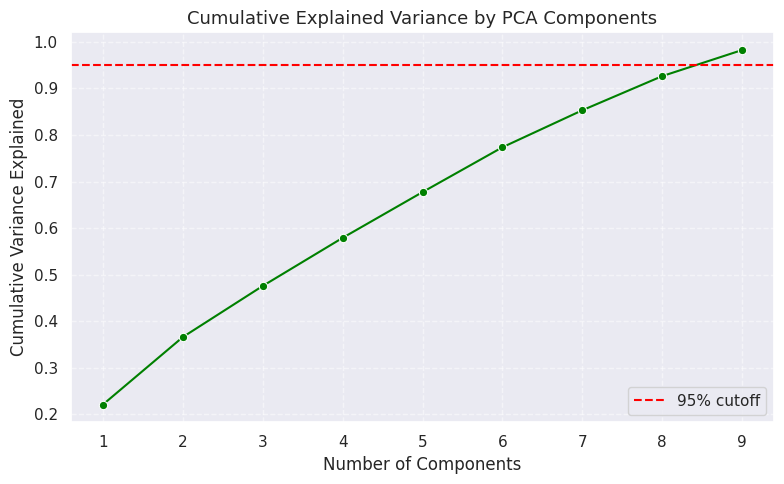

In [71]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_)+1),
             y=np.cumsum(pca.explained_variance_ratio_), marker='o', color='green')
plt.title('Cumulative Explained Variance by PCA Components', fontsize=13)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% cutoff')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### First 2 principal components - Visualization

In [72]:
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_num_scaled)

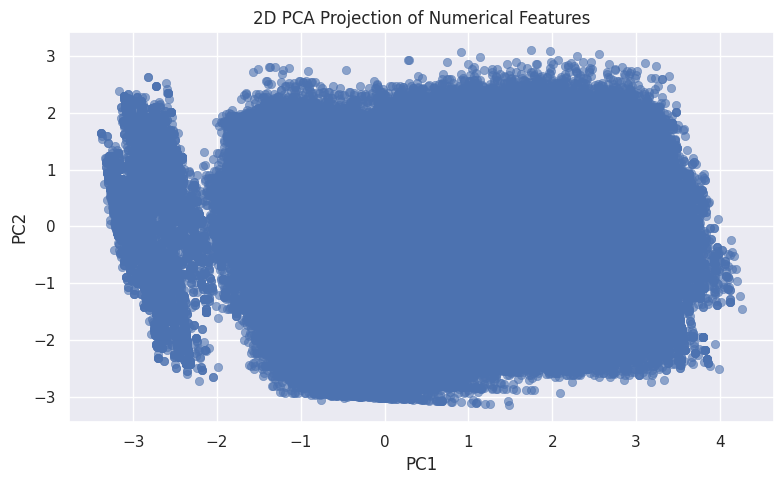

In [73]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca_2d[:,0], y=X_pca_2d[:,1], alpha=0.6, edgecolor=None)
plt.title('2D PCA Projection of Numerical Features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# Model Comparison: Gradient Boosting vs PCA + Linear Regression

### Fit and Evaluate PCA + Linear Regression

In [74]:
# Pipeline: scale -> PCA -> linear regression
pca_lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('regressor', LinearRegression())
])

In [75]:
# Fit on training numeric features only
pca_lr_pipeline.fit(X_train_full[num_cols], y_train_full)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95, random_state=42)),
                ('regressor', LinearRegression())])

In [76]:
# Predict on test set (numeric features only)
y_pred_lr = pca_lr_pipeline.predict(X_test_full[num_cols])
rmse_lr = np.sqrt(mean_squared_error(y_test_full, y_pred_lr))
r2_lr = r2_score(y_test_full, y_pred_lr)

print(f"PCA + Linear Regression RMSE: {rmse_lr: .2f}")
print(f"PCA + Linear Regression R2 Score: {r2_lr: .3f}")

PCA + Linear Regression RMSE:  0.71
PCA + Linear Regression R2 Score:  0.493


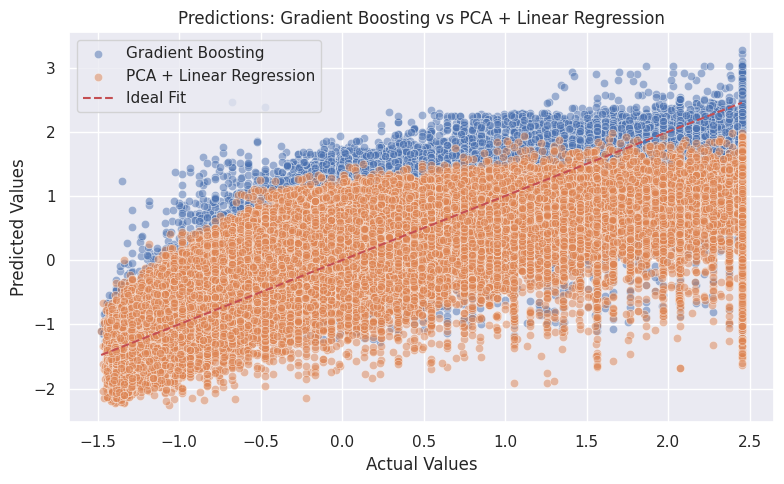

In [77]:
# Visual Comparison
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_full, y=y_pred_test, label='Gradient Boosting', alpha=0.5)
sns.scatterplot(x=y_test_full, y=y_pred_lr, label='PCA + Linear Regression', alpha=0.5)
plt.plot([y_test_full.min(), y_test_full.max()], [y_test_full.min(), y_test_full.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions: Gradient Boosting vs PCA + Linear Regression')
plt.legend()
plt.tight_layout()
plt.show()

# 8. Dimensionality Reduction (Non-Linear)

In [78]:
X_iso_sample = X_train_full[num_cols].sample(n=300, random_state=42)

In [79]:
# Scale numeric training data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_iso_sample)

### Isomap

In [80]:
isomap = Isomap(n_neighbors=5, n_components=2)
X_isomap = isomap.fit_transform(X_scaled)

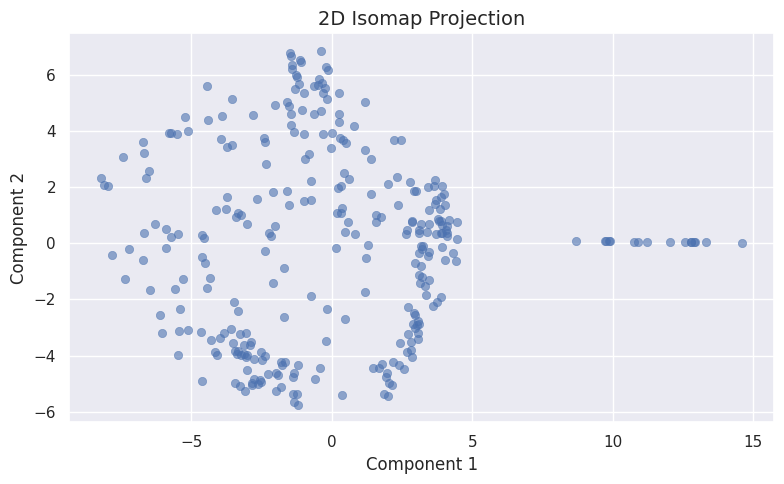

In [81]:
# Visualize the 2D Projection
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_isomap[:,0], y=X_isomap[:,1], alpha=0.6, edgecolor=None)
plt.title('2D Isomap Projection', fontsize=14)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()
plt.show()

**Observation:**

---


The Isomap projection reveals some global structure in the data. While there is
partial separation of clusters, the method shows limited ability to handle overlapping or complex local structures. This is expected, as Isomap is designed to preserve global geometric relationships.

### Comparison with t-SNE

In [82]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

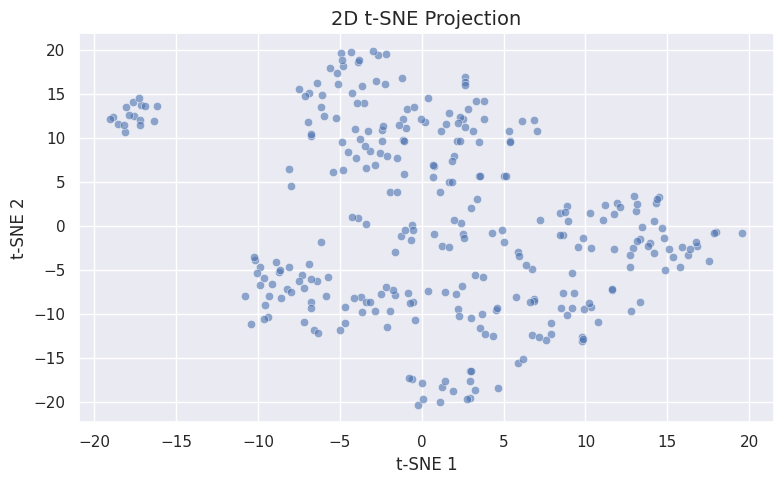

In [83]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], alpha=0.6)
plt.title('2D t-SNE Projection', fontsize=14)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

**Observation:**

---

The t-SNE visualization clearly reveals tight, distinguishable clusters, demonstrating its effectiveness in preserving local structure. This is particularly useful for exploratory analysis and understanding hidden patterns, although it is not suitable for use as input to predictive models due to its distortion of global relationships and non-deterministic behavior

In [84]:
# Clean up
del X_isomap, X_iso_sample, X_scaled, X_tsne
gc.collect()

17491

# 9. Polynomial Regression

### Prepare scaled numeric data

In [85]:
X_poly_base = X_train_full[num_cols].copy()

In [86]:
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly_base)

In [87]:
# Transform test set
X_poly_test_scaled = scaler.transform(X_test_full[num_cols])

### Generating Polynomial Features

In [88]:
# Degree=2 (quadratic)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_poly_scaled)
X_poly_test = poly.transform(X_poly_test_scaled)

print(f"Polynomial Features Shape: {X_poly_train.shape}")

Polynomial Features Shape: (233214, 65)


### Train Linear Regression on Polynomial Features

In [89]:
# Train
poly_reg = LinearRegression()
poly_reg.fit(X_poly_train, y_train_full)

LinearRegression()

In [90]:
# Predict
y_pred_poly = poly_reg.predict(X_poly_test)

In [91]:
# Evaluation
rmse_poly = np.sqrt(mean_squared_error(y_test_full, y_pred_poly))
r2_poly = r2_score(y_test_full, y_pred_poly)

print(f"Polynomial Regression RMSE: {rmse_poly: .2f}")
print(f"Polynomial Regression R2 Score: {r2_poly: .3f}")

Polynomial Regression RMSE:  0.61
Polynomial Regression R2 Score:  0.625


### Visualize Predictions vs Actual

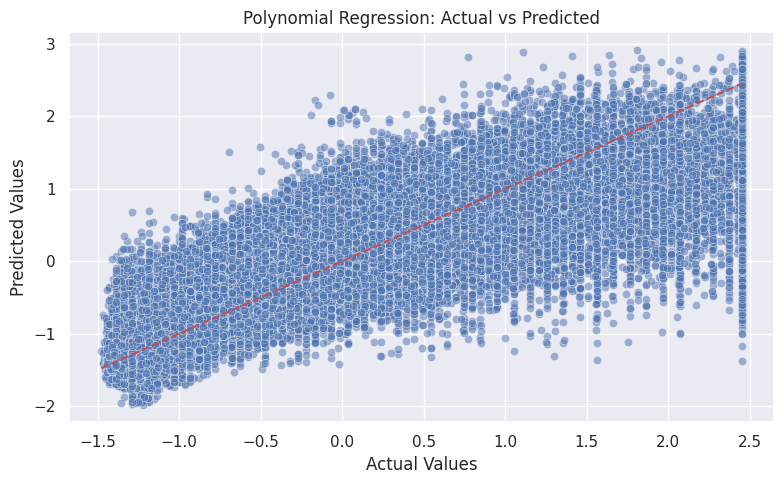

In [92]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_full, y=y_pred_poly, alpha=0.5)
plt.plot([y_test_full.min(), y_test_full.max()], [y_test_full.min(), y_test_full.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Polynomial Regression: Actual vs Predicted')
plt.tight_layout()
plt.show()

# 10. Clustering for Feature Engineering

In [93]:
# Scaling a sample
X_cluster_sample = X_train_full[num_cols].sample(n=1000, random_state=42)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster_sample)

### Determine Optimal k (Elbow Method)

In [94]:
inertia = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

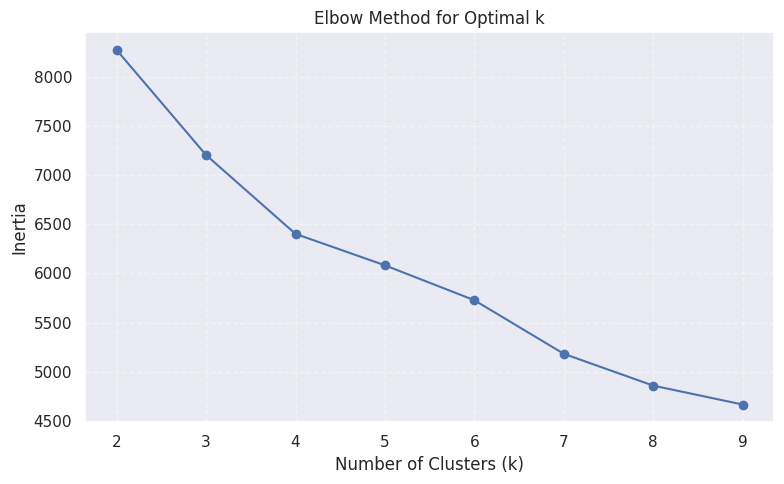

In [95]:
plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Evaluate Cluster Quality with Silhouette Score

In [96]:
# Scale entire training data
X_train_scaled = scaler.transform(X_train_full[num_cols])

In [97]:
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(X_cluster_scaled)
kmeans.fit(X_train_scaled)

KMeans(n_clusters=4, random_state=42)

In [98]:
silhouette = silhouette_score(X_cluster_scaled, clusters)
print(f"Silhouette Score: {silhouette: .3f}")

Silhouette Score:  0.184


### Visualize Clusters with PCA

In [99]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

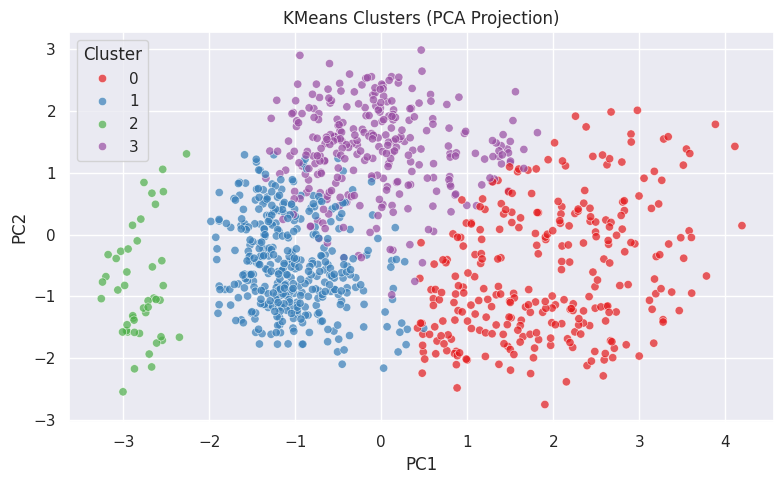

In [100]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='Set1', alpha=0.7)
plt.title('KMeans Clusters (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

### Adding Cluster Labels to Full Dataset

In [101]:
# Fit KMeans on all scaled numeric training data
X_train_scaled = scaler.transform(X_train_full[num_cols])
X_test_scaled = scaler.transform(X_test_full[num_cols])

In [102]:
# Predict full cluster labels
X_train_full['cluster_label'] = kmeans.predict(X_train_scaled)
X_test_full['cluster_label'] = kmeans.predict(X_test_scaled)

In [103]:
selected_features = num_cols.copy()

In [104]:
if 'cluster_label' not in selected_features:
    selected_features.append('cluster_label')

### Visualize Cluster Centers

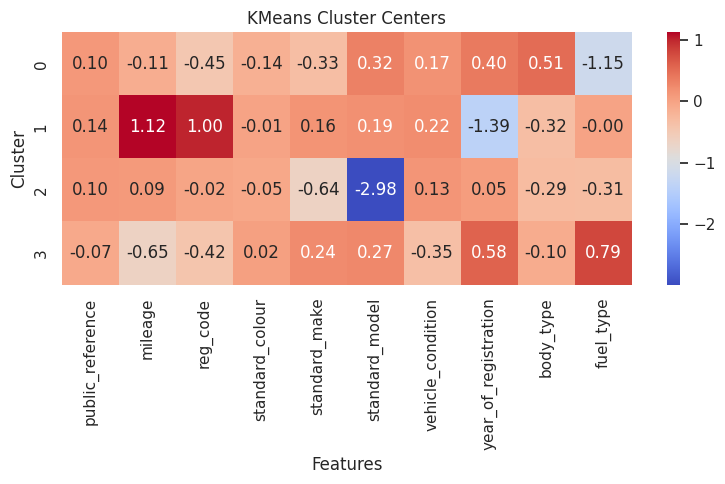

In [105]:
centres = pd.DataFrame(kmeans.cluster_centers_, columns=num_cols)

plt.figure(figsize=(8,5))
sns.heatmap(centres, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('KMeans Cluster Centers')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()